# Notebook made by  

__Name(s)__: Afra Baas & Stijn Hamerslag & Isa-Ali Kirca & Juno Prent

__Student id(s)__ : 12417505 & 1323795 & 12014672 & 11915307


__This notebook has been made to plot the results with the metric which is the most comparable to the plot of the authors (last accuracy/parity/bias). Please keep in mind that:__

> This is only applicable if the provided datasets are used (german, compas and drug).

> Plots can onle be made if all the datasets together with all their attacks have been run with epsilons from 0.0 up to 1, otherwise it will most likely throw errors.

In [133]:
import glob
import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [134]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [135]:
# seed still needs to be implemented
def get_test_dicts(dataset, data_choice, methods, folder_measure, measure):
    # make the dicts
    last_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    # find all the files for the dataset
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, folder_measure)):
        for method in methods:
            if method in file_name:
                # strip the methods (/IAF-) etc. 
                meth = method[1:-1]
                splits = file_name.split("_")
                # find the epsilon in the filename 
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                # if there are nans in the data, skip them
                measured = data[~data[measure].isna()][measure]
                
                if measure == "test_acc":
                    # calculate test error
                    last_dict[meth][epsilon] = 1 - measured[measured.index[-1]]
                    
                else:
                    last_dict[meth][epsilon] = measured[measured.index[-1]] 

    return last_dict 


# same holds for this function, but this time we save the iterations and time taken
# which you have to run once for the time and one for the iterations
def get_time_and_it_dicts(dataset, data_choice, methods, time_and_it_folder, t_i_col):
    dict_ = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, time_and_it_folder)):
        for method in methods:
            if method in file_name:
                meth = method[1:-1]
                splits = file_name.split("_")
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                measured = data[~data[t_i_col].isna()][t_i_col]
                
                dict_[meth][epsilon] = measured[measured.index[-1]]
    return dict_

In [156]:
def plot_seed(datasets, data_choice, methods, folder_measure, measure, time_and_it, t_i_col):    
    # ta = test accuracy
    german_last_ta_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[0], measures[0])
    compas_last_ta_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[0], measures[0])
    drug_last_ta_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[0], measures[0])
    
    
    # concat all three dicts into one df
    acc_df = pd.concat({'German acc': pd.DataFrame(german_last_ta_dict), 
                        'COMPAS acc': pd.DataFrame(compas_last_ta_dict), 
                        'Drug consumption acc': pd.DataFrame(drug_last_ta_dict)}).unstack(0).sort_index(axis = 0)
    

    # p = parity
    german_last_p_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[1])
    compas_last_p_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[1])
    drug_last_p_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[1])
    
    # concat all three dicts into one df
    p_df = pd.concat({'German par': pd.DataFrame(german_last_p_dict), 
                      'COMPAS par': pd.DataFrame(compas_last_p_dict), 
                      'Drug consumption par': pd.DataFrame(drug_last_p_dict)}).unstack(0).sort_index(axis = 0)

    # b = biases
    german_last_b_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[2])
    compas_last_b_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[2])
    drug_last_b_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[2])
    
    # concat all three dicts into one df
    b_df = pd.concat({'German bias': pd.DataFrame(german_last_b_dict), 
                      'COMPAS bias': pd.DataFrame(compas_last_b_dict), 
                      'Drug consumption bias': pd.DataFrame(drug_last_b_dict)}).unstack(0).sort_index(axis = 0)
    
    # to be able to make a plot loop
    dfs = [acc_df, p_df, b_df]
    
    ylabels = ["Test error", "Statistical parity", "Equality of opportunity"]
    lines = ['b-s', 'g-^', 'r-D']
    fig, axs = plt.subplots(3,3, figsize=(15, 10))
    axs = axs.ravel()
    
    fig.suptitle("{}".format(data_choice), fontsize=20, fontweight='heavy')
    
    for i in range(9):
        a = 0
        for j in range(0,9,3):
            t = i % 3
            
            # makes sure everything works as it has to
            if i <= 2:
                j += 0
            elif i > 2 and i <= 5:
                j += 1  
            elif i > 5:
                j += 2
                
            col = dfs[t].columns[j]
            column_data = dfs[t][col]

            axs[i].plot(column_data, lines[a], label="{}".format(column_data.name[0]))
            axs[i].set_title("{}".format(column_data.name[1].split(" ")[0]), fontweight='bold')
            axs[i].set_xlabel('Epsilon', fontweight='heavy')
            
            if "acc" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[0], fontweight='heavy')
            elif "par" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[1], fontweight='heavy')
            else:
                axs[i].set_ylabel(ylabels[2], fontweight='heavy')
            
            axs[i].legend(loc=9, ncol=3)
            axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]) 
            axs[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, "", ""])
    
            a += 1
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)
    plt.show()
    
    # show time taken and number of iterations in a dataframe
    time_taken_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], 
                                         data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    
    
    last_iter_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    
    german_df = pd.concat({"Time (s)":time_taken_g, "# iters":last_iter_g}).unstack(0)
    compas_df = pd.concat({"Time (s)":time_taken_c, "# iters":last_iter_c}).unstack(0)
    drug_df = pd.concat({"Time (s)":time_taken_d, "# iters":last_iter_d}).unstack(0)
    german_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    
    

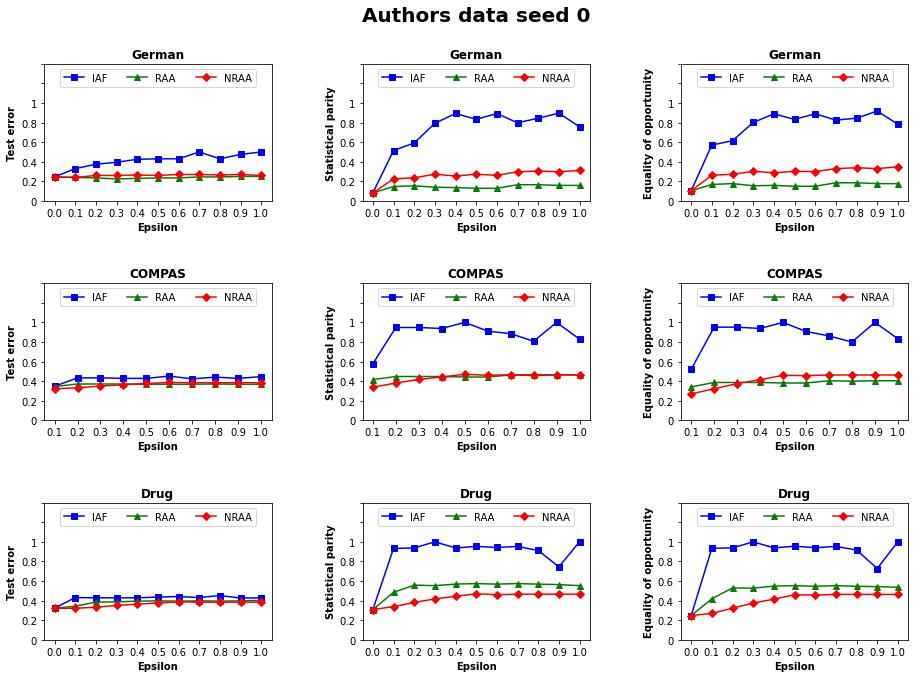

In [158]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)

Make sure you **change the data_choice** (original data or authors data). So only the second parameter of plot_seed. The model automatically saves the data choice as:

    - dataset_choice: x seed y
    
with:

**x**: $\left\{\begin{array}{l}\text{Original data} \;\;\;\;\;\; \text { if  x == --original_data y} \;\; \text{OR} \;\; \text{x == --original_data yes} \\ \text{Authors data} \;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**y**: $\left\{\begin{array}{l}y \in \{1,2,3\} \;\;\;\;\;\; \text { if  y == --rand_seed 1} \;\; \text{OR} \;\; \text{y == --rand_seed 2} \;\; \text{OR} \;\; \text{y == --rand_seed 3} \\ \text{0} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text { otherwise }\end{array}\right.$

In [110]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [104]:
# Make sure to change the second parameter, i.e. the string 

# plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
#           time_and_it, time_and_it_columns)

In [132]:
import glob

dataset_names = ["data.npz", "german_group_label.npz", "compas_data.npz", "compas_group_label.npz", "drug2_data.npz", "drug2_group_label.npz"]

for i in glob.glob(os.path.join("..", "original_data", "*")):
    print(i.split(os.path.join("original_data", " ").strip())[1])
#      if i.split("original_data/")[1] in dataset_names:
#             print("YEs")

make_datasets_notebook.ipynb
make_datasets.py
resources
compas_data.npz
__init__.py
__pycache__
drug2_data.npz
compas_group_label.npz
german_group_label.npz
data.npz
drug2_group_label.npz
